# Movinet Streaming Model Fine Tuning

## Install cecessary libraries

In [1]:
!pip uninstall numpy tensorflow pandas
!pip install numpy==1.26.4 tensorflow==2.18.0 pandas==2.2.2
!pip install tensorflow-model-optimization tf-models-official tensorflow-text google-colab
!pip install remotezip

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.11/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.26.4
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.11/dist-packages/tensorflow-2.18.0.dist-info/*
    /usr/local/lib/python3.11/dist-package

## Import necessary libraries

In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tf_keras import callbacks, optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Import the MoViNet model from TensorFlow Models (tf-models-official)

In [3]:
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

## Download Subdataset of UCF_101

In [4]:
!gdown 1CPH5XA3XWtn7dq1zkmcy14U1hSAURBdn
!unzip "UCF101_split_augmented_with_val.zip"

Streaming output truncated to the last 5000 lines.
  inflating: UCF101_augmented_with_val/train/PushUps/v_PushUps_g21_c01.mp4  
  inflating: UCF101_augmented_with_val/train/PushUps/v_PushUps_g20_c02_blurred.mp4  
  inflating: UCF101_augmented_with_val/train/PushUps/v_PushUps_g16_c02_darkened.mp4  
  inflating: UCF101_augmented_with_val/train/PushUps/v_PushUps_g06_c04.mp4  
  inflating: UCF101_augmented_with_val/train/PushUps/v_PushUps_g02_c01_darkened.mp4  
  inflating: UCF101_augmented_with_val/train/PushUps/v_PushUps_g23_c04_darkened.mp4  
  inflating: UCF101_augmented_with_val/train/PushUps/v_PushUps_g20_c01_flipped.mp4  
  inflating: UCF101_augmented_with_val/train/PushUps/v_PushUps_g08_c04.mp4  
  inflating: UCF101_augmented_with_val/train/PushUps/v_PushUps_g16_c04_blurred.mp4  
  inflating: UCF101_augmented_with_val/train/PushUps/v_PushUps_g02_c03_darkened.mp4  
  inflating: UCF101_augmented_with_val/train/PushUps/v_PushUps_g09_c03_flipped.mp4  
  inflating: UCF101_augmented_with

## Prepare train, valid and test dataset

In [5]:
def frames_from_video_file(video_path, n_frames, frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """

  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(tf.image.convert_image_dtype(frame, tf.float32))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = tf.image.convert_image_dtype(frame, tf.float32)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, class_ids_for_name, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_ids_for_name = class_ids_for_name

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name]
      yield video_frames, label

In [6]:
train_path = Path("/content/UCF101_augmented_with_val/train")
test_path = Path("/content/UCF101_augmented_with_val/test")
val_path = Path("/content/UCF101_augmented_with_val/val")
batch_size = 8
num_frames = 8

class_names = sorted(set(p.name for p in train_path.iterdir() if p.is_dir()))
class_ids_for_name = dict((name, idx) for idx, name in enumerate(class_names))

In [7]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

# Train dataset
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_path,
                                                         class_ids_for_name,
                                                         num_frames,
                                                         training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

# Validation dataset
val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_path,
                                                       class_ids_for_name,
                                                       num_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

# Test dataset
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_path,
                                                        class_ids_for_name,
                                                        num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

In [8]:
np.save("../labels.npy", np.array(list(class_ids_for_name)))

### Check the prepared training batch of the data

In [9]:
class_ids_for_name

{'ApplyEyeMakeup': 0,
 'ApplyLipstick': 1,
 'Archery': 2,
 'BaseballPitch': 3,
 'Basketball': 4,
 'BenchPress': 5,
 'Biking': 6,
 'Billiards': 7,
 'BlowDryHair': 8,
 'BlowingCandles': 9,
 'Diving': 10,
 'GolfSwing': 11,
 'PullUps': 12,
 'PushUps': 13,
 'SoccerPenalty': 14,
 'TennisSwing': 15}

In [10]:
for frames, labels in train_ds.take(1):
  print(f"Shape: {frames.shape}")
  print(f"Label: {labels.shape}")
  print(labels)

Shape: (8, 8, 172, 172, 3)
Label: (8,)
tf.Tensor([ 5  7 13  8 14  2  8  2], shape=(8,), dtype=int16)


### Set up the distribution strategy

In [11]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


### Construct the backbone for Movinet

In [12]:
# Extract pretrained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_stream.tar.gz -O movinet_a0_stream.tar.gz -q
!tar -xvf movinet_a0_stream.tar.gz

movinet_a0_stream/
movinet_a0_stream/ckpt-1.data-00000-of-00001
movinet_a0_stream/ckpt-1.index
movinet_a0_stream/checkpoint


In [13]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = 172

backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=False,
)

### Load pre-trained checkpoint and modify classifier

In [14]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

# Construct loss, optimizer and compile the model
with distribution_strategy.scope():

  model = build_classifier(batch_size, num_frames, 172, backbone, len(class_names))
  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizer = optimizers.legacy.Adam(learning_rate=0.0001)

  checkpoint_dir = 'movinet_a0_stream'
  checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
  checkpoint = tf.train.Checkpoint(backbone=backbone)
  status = checkpoint.restore(checkpoint_path).expect_partial()

  model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

## Create a callback for storing the checkpoints

In [15]:
checkpoint_dir = "/content/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "a0_augmented.weights.h5")

# Checkpoint callback to save best model
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        save_weights_only=True,
                                        verbose=1)

# Early stopping callback to stop if model can't improve
es_callback = callbacks.EarlyStopping(monitor='val_loss',
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1,
                                      mode='auto',
                                      baseline=None,
                                      start_from_epoch=0)

# Schedule to adjust learning rate
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

## Train the model

In [16]:
results = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    validation_freq=1,
                    verbose=1,
                    callbacks=[cp_callback, es_callback, lr_scheduler])

Epoch 1/20
    757/Unknown - 196s 209ms/step - loss: 1.9932 - accuracy: 0.3588
Epoch 1: saving model to /content/checkpoints/a0_augmented.weights.h5
757/757 [==============================] - 236s 262ms/step - loss: 1.9932 - accuracy: 0.3588 - val_loss: 1.4114 - val_accuracy: 0.5416 - lr: 1.0000e-04
Epoch 2/20
757/757 [==============================] - ETA: 0s - loss: 1.2643 - accuracy: 0.5785
Epoch 2: saving model to /content/checkpoints/a0_augmented.weights.h5
757/757 [==============================] - 187s 247ms/step - loss: 1.2643 - accuracy: 0.5785 - val_loss: 0.8247 - val_accuracy: 0.7334 - lr: 1.0000e-04
Epoch 3/20
757/757 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.6938
Epoch 3: saving model to /content/checkpoints/a0_augmented.weights.h5
757/757 [==============================] - 187s 247ms/step - loss: 0.8867 - accuracy: 0.6938 - val_loss: 0.5863 - val_accuracy: 0.8143 - lr: 1.0000e-04
Epoch 4/20
757/757 [==============================] - ETA: 0s -

## Plot loss

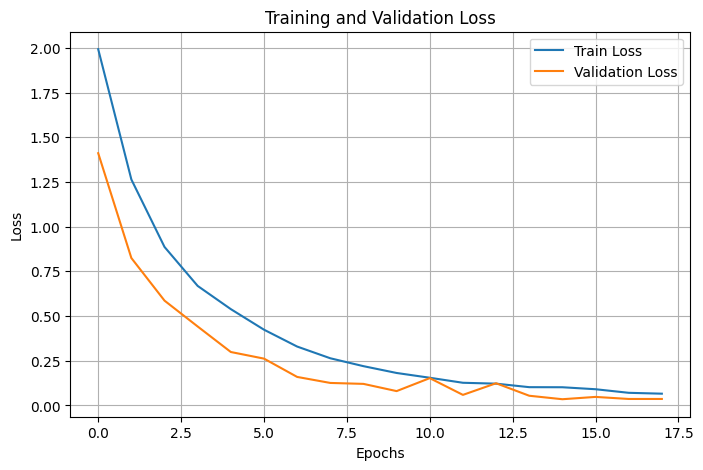

In [21]:
%matplotlib inline
# Plot loss and accuracy over epoch
history = results.history
train_loss = history['loss']
val_loss = history['val_loss']

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

## Evaluate the model

In [22]:
model.evaluate(test_ds)

164/164 [==============================] - 31s 192ms/step - loss: 0.0407 - accuracy: 0.9840


[0.04073118418455124, 0.9839938879013062]